In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import math
import pandas as pd
from glob import iglob
import numpy as np
from keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular
import time
from utils import plot_confusion_matrix
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
print('Loading mirai data')
df_ack = pd.concat((pd.read_csv(f) for f in iglob('../data/**/mirai_attacks/ack.csv', recursive=True)), ignore_index=True)
df_ack['class'] = 'ack'
df_scan = pd.concat((pd.read_csv(f) for f in iglob('../data/**/mirai_attacks/scan.csv', recursive=True)), ignore_index=True)
df_scan['class'] = 'scan' 
df_syn = pd.concat((pd.read_csv(f) for f in iglob('../data/**/mirai_attacks/syn.csv', recursive=True)), ignore_index=True)
df_syn['class'] = 'syn'
df_udp = pd.concat((pd.read_csv(f) for f in iglob('../data/**/mirai_attacks/udp.csv', recursive=True)), ignore_index=True)
df_udp['class'] = 'udp'
df_udpplain = pd.concat((pd.read_csv(f) for f in iglob('../data/**/mirai_attacks/udpplain.csv', recursive=True)), ignore_index=True)
df_udpplain['class'] = 'udpplain'

Loading mirai data


In [3]:
classes = ['ack', 'scan', 'syn', 'udp', 'udpplain']

In [4]:
def create_model(input_dim, hidden_layer_size, num_of_classes):
    model = Sequential()
    model.add(Dense(hidden_layer_size, activation="tanh", input_shape=(input_dim,)))
    model.add(Dense(hidden_layer_size, activation="tanh"))
    model.add(Dense(num_of_classes))
    model.add(Activation('softmax'))
    return model

In [5]:
df = df_ack.sample(n=100000, random_state=42).append(df_scan.sample(n=100000, random_state=42)).append(df_syn.sample(n=100000, random_state=42)).append(df_udp.sample(n=100000, random_state=42)).append(df_udpplain.sample(n=100000, random_state=42))

In [6]:
scored = []
indices = {}
shps = {}
for cl in classes:
    indices[cl] = df['class'] == cl
    shps[cl] =  df[indices[cl]].shape[0]

for col in df.columns:
    if col == 'class':
        continue
    num = 0
    den = 0
    m = df[col].mean()
    
    for cl in classes:
        num += (shps[cl] / df.shape[0]) * (m - df[indices[cl]][col].mean())**2
        den += (shps[cl] / df.shape[0]) * df[indices[cl]][col].var()

    score = {'feature': col, 'score': num / den if den else 0}
    scored.append(score)
    #print(score)
scored.sort(key=lambda x: x['score'], reverse=True)
scored[:10]

ok


[{'feature': 'MI_dir_L0.01_variance', 'score': 43.74551499994631},
 {'feature': 'H_L0.01_variance', 'score': 43.74551499994631},
 {'feature': 'MI_dir_L0.1_variance', 'score': 41.42778387265704},
 {'feature': 'H_L0.1_variance', 'score': 41.42778387265704},
 {'feature': 'MI_dir_L0.01_mean', 'score': 30.054625413474774},
 {'feature': 'H_L0.01_mean', 'score': 30.054625413474774},
 {'feature': 'MI_dir_L0.1_mean', 'score': 27.032047970892567},
 {'feature': 'H_L0.1_mean', 'score': 27.032047970892567},
 {'feature': 'MI_dir_L1_variance', 'score': 19.621471677625625},
 {'feature': 'H_L1_variance', 'score': 19.621471677625625}]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['class']), pd.get_dummies(df['class']), test_size=0.2, random_state=42)

In [9]:
x_train.shape

(400000, 115)

In [10]:
x_test.shape

(100000, 115)

In [11]:
acs = []
for top_n_features in [115]:
    fs = [it['feature'] for it in scored[:top_n_features]]
    print('-----N' + str(top_n_features))
    scaler = StandardScaler()
    print('Transforming data')
    X_train = scaler.fit_transform(x_train[fs])
    X_test = scaler.transform(x_test[fs])
    model = create_model(top_n_features, 8, 5)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    cp = ModelCheckpoint(filepath=f'./models/model_atk_types_dif.h5',
                                   save_best_only=True,
                                   verbose=0)
    es = EarlyStopping(patience=3, monitor='val_loss')
    epochs = 100
    start=time.time()
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        validation_split=0.2,
                        verbose=1,
                        callbacks=[cp, es])
    #model = load_model(f'./models/model_atk_types{top_n_features}.h5')
    print('time ' + str(time.time() - start))
        #print('Model evaluation')
    print('Loss, Accuracy')
    ev = model.evaluate(X_test, y_test)
    print(ev)
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)
    y_test_classes = np.argmax(y_test.values, axis=1)
    print('accuracy')
    acc = accuracy_score(y_test_classes, y_pred_classes)
    print(acc)
    acs.append(acc)
    cnf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

-----N115
Transforming data
Train on 320000 samples, validate on 80000 samples
Epoch 1/100
320000/320000 [==============================] - 17s 54us/step - loss: 0.2373 - acc: 0.9103 - val_loss: 0.1267 - val_acc: 0.9538
Epoch 2/100
320000/320000 [==============================] - 15s 46us/step - loss: 0.0795 - acc: 0.9758 - val_loss: 0.0609 - val_acc: 0.9783
Epoch 3/100
320000/320000 [==============================] - 14s 44us/step - loss: 0.0448 - acc: 0.9871 - val_loss: 0.0313 - val_acc: 0.9923
Epoch 4/100
320000/320000 [==============================] - 14s 45us/step - loss: 0.0329 - acc: 0.9910 - val_loss: 0.0278 - val_acc: 0.9919
Epoch 5/100
320000/320000 [==============================] - 15s 47us/step - loss: 0.0255 - acc: 0.9930 - val_loss: 0.0178 - val_acc: 0.9959
Epoch 6/100
320000/320000 [==============================] - 14s 45us/step - loss: 0.0208 - acc: 0.9946 - val_loss: 0.0144 - val_acc: 0.9967
Epoch 7/100
320000/320000 [==============================] - 14s 44us/step 

Confusion matrix, without normalization
[[19995     0     2    13    20]
 [    0 19989     0     0     2]
 [    2     1 19863     0     0]
 [   20     1     0 19978    70]
 [   10     0     2    18 20014]]


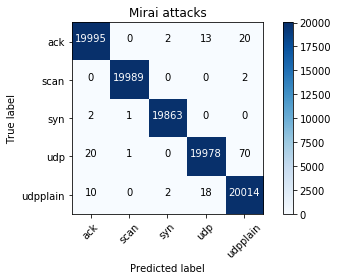

In [12]:
plot_confusion_matrix(cnf_matrix, classes, title='Mirai attacks')

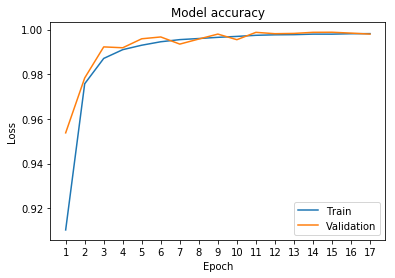

In [14]:
plt.plot(range(1,18), history.history['acc'])
plt.plot(range(1,18), history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.xticks(list(range(1,18)))
plt.show()

In [ ]:
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.xticks([2,5,10,20,30,40,50,60,70,80,90,100,115])
plt.plot([2,3,4,5,6,7,8], acs)

In [10]:
class ModelWrapper:
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler

    def scale_predict(self, x):
        x = self.scaler.transform(x)
        return self.model.predict(x)

In [11]:
m = ModelWrapper(model, scaler)

In [12]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train[fs].values, feature_names=fs, class_names=classes, discretize_continuous=True)

In [23]:
exp = explainer.explain_instance(df_udp[fs].values[76], m.scale_predict, num_features=5, top_labels=2)
exp.show_in_notebook(show_table=True, show_all=False)

In [14]:
exp.as_list(label=3)

[('HpHp_L0.1_weight <= 1.00', 0.15497182668727877),
 ('HpHp_L1_weight <= 1.00', 0.13067856358771368),
 ('HpHp_L3_weight <= 1.00', 0.11465821503679595),
 ('HpHp_L0.01_weight <= 1.00', 0.10179069875232108),
 ('MI_dir_L0.1_weight <= 3214.80', 0.072905719411177)]

In [85]:
df_gafgyt = pd.concat((pd.read_csv(f) for f in iglob('../data/**/gafgyt_attacks/scan.csv', recursive=True)), ignore_index=True)


In [89]:
ii = 99332
["{0:.2f}".format(s) for s in m.scale_predict(df_gafgyt[fs].values[ii:ii+1])[0]]

['0.00', '1.00', '0.00', '0.00', '0.00']